<p style="text-align:center">
    <a href="https://skills.network/?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMDeveloperSkillsNetworkML0101ENSkillsNetwork20718538-2022-01-01">
    <img src="https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/assets/logos/SN_web_lightmode.png" width="200" alt="Skills Network Logo"  />
    </a>
</p>

<h1 align="center"><font size="5">Deep Learning and Reinforcement Learning - Final Assignment</font></h1>


In [130]:
import os
import kagglehub
import json
import re
import pandas as pd
import numpy as np
import seaborn as sns
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import multilabel_confusion_matrix, precision_score, recall_score, f1_score
from pydantic import BaseModel
from model import NERModel
import matplotlib.pyplot as plt

# Introduction

### Medical NER Dataset

url: https://www.kaggle.com/datasets/finalepoch/medical-ner/data

This dataset was created to train a Spacy model to perform Named Entity Recognition for three categories:

Medical condition names (example: influenza, headache, malaria) \
Medicine names (example : aspirin, penicillin, ribavirin, methotrexate) \
Pathogens ( example: Corona Virus, Zika Virus, cynobacteria, E. Coli)

## Goal

I will be using the Resume Entities for NER dataset from Kaggle, which is used to train models to extract experience and skills information from CVs. I will be training an LSTM using tensorflow and keras to create customised layers.

## 1. EDA

So I am going to first load the file as json, then load the examples into a pandas dataframe. Then I will perform some EDA.

### 1.1 Data Loading

In [88]:
dataset_path = kagglehub.dataset_download("finalepoch/medical-ner")
print(f"dataset_path: {dataset_path}")

dataset_path: /home/mbarbaric/.cache/kagglehub/datasets/finalepoch/medical-ner/versions/5


In [89]:
corona_2_file_path = os.path.join(dataset_path, 'Corona2.json')
corona_2_file_path

'/home/mbarbaric/.cache/kagglehub/datasets/finalepoch/medical-ner/versions/5/Corona2.json'

In [90]:
with open(corona_2_file_path, 'r') as f:
    corona2_json_file = json.loads(f.read())

In [91]:
corona2_json_file['examples']

[{'id': '18c2f619-f102-452f-ab81-d26f7e283ffe',
  'content': "While bismuth compounds (Pepto-Bismol) decreased the number of bowel movements in those with travelers' diarrhea, they do not decrease the length of illness.[91] Anti-motility agents like loperamide are also effective at reducing the number of stools but not the duration of disease.[8] These agents should be used only if bloody diarrhea is not present.[92]\n\nDiosmectite, a natural aluminomagnesium silicate clay, is effective in alleviating symptoms of acute diarrhea in children,[93] and also has some effects in chronic functional diarrhea, radiation-induced diarrhea, and chemotherapy-induced diarrhea.[45] Another absorbent agent used for the treatment of mild diarrhea is kaopectate.\n\nRacecadotril an antisecretory medication may be used to treat diarrhea in children and adults.[86] It has better tolerability than loperamide, as it causes less constipation and flatulence.[94]",
  'metadata': {},
  'annotations': [{'id': '08

In [92]:
ner_df = pd.DataFrame.from_records(corona2_json_file['examples'])
ner_df.head()

,id,content,metadata,annotations,classifications
0,18c2f619-f102-452f-ab81-d26f7e283ffe,While bismuth compounds (Pepto-Bismol) decreas...,{},[{'id': '0825a1bf-6a6e-4fa2-be77-8d104701eaed'...,[]
1,487c93e3-0d45-4088-a378-cf3a01c8953d,"Diarrhea, also spelled diarrhoea, is the condi...",{},[{'id': '28601a42-c8a9-44e2-aeea-8939cb1db1a9'...,[]
2,d5056874-895a-4a7f-9e0f-828d414d65d9,Antiretroviral therapy (ART) is recommended fo...,{},[{'id': '0a4b4cc2-3a07-4817-8ccc-8fa1f945573d'...,[]
3,20c792c7-0c4b-42d0-8127-0e04113db384,The following drugs are considered as DMARDs: ...,{},[{'id': '0e370ff5-fee6-45e1-adcb-d5f00fa33b0d'...,[]
4,f5359e0d-4d4a-4707-95a3-4c627fc4a83b,"The goals of treatment are to reduce pain, dec...",{},[{'id': '10411ff5-e343-40bf-95d5-39cd1cb16060'...,[]


In [93]:
ner_df.columns

Index(['id', 'content', 'metadata', 'annotations', 'classifications'], dtype='object')

In [94]:
ner_df.isna().sum()

id                 0
content            0
metadata           0
annotations        0
classifications    0
dtype: int64

In [95]:
ner_df.dtypes

id                 object
content            object
metadata           object
annotations        object
classifications    object
dtype: object

For the purpose of this workbook, I will only be using the content and annotations objects for creating the training data. Before that I will start to review the layout of the annotations columns to see what preprocessing needs to be completed to generate the training data.

### 1.2 Content Analysis

Lets take a look at the first entry to get an idea of what we are looking at.

In [96]:
ner_df.iloc[0]['content']

"While bismuth compounds (Pepto-Bismol) decreased the number of bowel movements in those with travelers' diarrhea, they do not decrease the length of illness.[91] Anti-motility agents like loperamide are also effective at reducing the number of stools but not the duration of disease.[8] These agents should be used only if bloody diarrhea is not present.[92]\n\nDiosmectite, a natural aluminomagnesium silicate clay, is effective in alleviating symptoms of acute diarrhea in children,[93] and also has some effects in chronic functional diarrhea, radiation-induced diarrhea, and chemotherapy-induced diarrhea.[45] Another absorbent agent used for the treatment of mild diarrhea is kaopectate.\n\nRacecadotril an antisecretory medication may be used to treat diarrhea in children and adults.[86] It has better tolerability than loperamide, as it causes less constipation and flatulence.[94]"

In [97]:
ner_df.iloc[2]['content']

'Antiretroviral therapy (ART) is recommended for all HIV-infected individuals to reduce the risk of disease progression.\nART also is recommended for HIV-infected individuals for the prevention of transmission of HIV.\nPatients starting ART should be willing and able to commit to treatment and understand the benefits and risks of therapy and the importance of adherence. Patients may choose to postpone therapy, and providers, on a case-by-case basis, may elect to defer therapy on the basis of clinical and/or psychosocial factors.'

In [98]:
ner_df.iloc[17]['content']

'If a tuberculosis infection does become active, it most commonly involves the lungs (in about 90% of cases).[14][17] Symptoms may include chest pain and a prolonged cough producing sputum. About 25% of people may not have any symptoms (i.e. they remain "asymptomatic").[14] Occasionally, people may cough up blood in small amounts, and in very rare cases, the infection may erode into the pulmonary artery or a Rasmussen\'s aneurysm, resulting in massive bleeding.[9][18] Tuberculosis may become a chronic illness and cause extensive scarring in the upper lobes of the lungs. The upper lung lobes are more frequently affected by tuberculosis than the lower ones.[9] The reason for this difference is not clear.[13] It may be due to either better air flow,[13] or poor lymph drainage within the upper lungs.['

Initial points:

- need to address bracketed text which represents citations [91]
- need to decide whether to lower-case all entries. If that is the case then labels will need to be lower cased as well (ART, HIV are labelled with uppercase)
- is there any need for numerical values? If not this will make preperocessing and removing citations alot easier.

In [99]:
ner_df['content_length'] = ner_df['content'].str.len()

<Axes: >

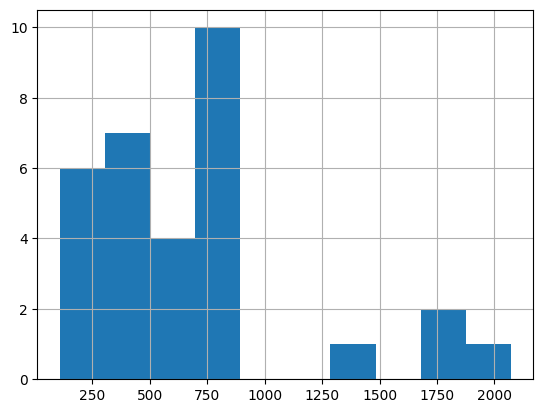

In [100]:
ner_df['content_length'].hist()

### 1.3 Annotations Analysis

In [101]:
first_annotation = ner_df.iloc[0]['annotations']
first_annotation

[{'id': '0825a1bf-6a6e-4fa2-be77-8d104701eaed',
  'tag_id': 'c06bd022-6ded-44a5-8d90-f17685bb85a1',
  'end': 371,
  'start': 360,
  'example_id': '18c2f619-f102-452f-ab81-d26f7e283ffe',
  'tag_name': 'Medicine',
  'value': 'Diosmectite',
  'correct': None,
  'human_annotations': [{'timestamp': '2020-03-21T00:24:32.098000Z',
    'annotator_id': 1,
    'tagged_token_id': '0825a1bf-6a6e-4fa2-be77-8d104701eaed',
    'name': 'Ashpat123',
    'reason': 'exploration'}],
  'model_annotations': []},
 {'id': '145f62b1-bbf5-42f1-8ad5-9c7e08337bf0',
  'tag_id': 'c06bd022-6ded-44a5-8d90-f17685bb85a1',
  'end': 408,
  'start': 383,
  'example_id': '18c2f619-f102-452f-ab81-d26f7e283ffe',
  'tag_name': 'Medicine',
  'value': 'aluminomagnesium silicate',
  'correct': None,
  'human_annotations': [{'timestamp': '2020-03-21T00:24:43.692000Z',
    'annotator_id': 1,
    'tagged_token_id': '145f62b1-bbf5-42f1-8ad5-9c7e08337bf0',
    'name': 'Ashpat123',
    'reason': 'exploration'}],
  'model_annotations':

In [102]:
second_start = first_annotation[1]['start']
second_end = first_annotation[1]['end']
print(f"start: {second_start}, end: {second_end}")

start: 383, end: 408


In [103]:
first_content = ner_df.iloc[0]['content']
first_content

"While bismuth compounds (Pepto-Bismol) decreased the number of bowel movements in those with travelers' diarrhea, they do not decrease the length of illness.[91] Anti-motility agents like loperamide are also effective at reducing the number of stools but not the duration of disease.[8] These agents should be used only if bloody diarrhea is not present.[92]\n\nDiosmectite, a natural aluminomagnesium silicate clay, is effective in alleviating symptoms of acute diarrhea in children,[93] and also has some effects in chronic functional diarrhea, radiation-induced diarrhea, and chemotherapy-induced diarrhea.[45] Another absorbent agent used for the treatment of mild diarrhea is kaopectate.\n\nRacecadotril an antisecretory medication may be used to treat diarrhea in children and adults.[86] It has better tolerability than loperamide, as it causes less constipation and flatulence.[94]"

In [104]:
first_content[second_start: second_end]

'aluminomagnesium silicate'

So it looks the the start and end values represent the character positions of the tokens within the text.

### 1.4 Feature Extraction

Training data needs to be aggregated so that the LSTM is passed in training data as a list of tokens with appropriate labels as below

| content_id | token    | label |
| -----      | ----     | ---   |
| 1          | pencilin | 1     |
| 1          | is       | 0     |


In [105]:
first_column = ner_df.iloc[0]
first_column

id                              18c2f619-f102-452f-ab81-d26f7e283ffe
content            While bismuth compounds (Pepto-Bismol) decreas...
metadata                                                          {}
annotations        [{'id': '0825a1bf-6a6e-4fa2-be77-8d104701eaed'...
classifications                                                   []
content_length                                                   885
Name: 0, dtype: object

### Helper Methods

The below helper methods are used to convert the existing NER Dataset into something that can be used as training data.

In [131]:
from enum import IntEnum, Enum

class NERLabelType(IntEnum):
    OOV = 0
    B_COND = 1
    I_COND = 2
    B_NAME = 3
    I_NAME = 4
    B_PATH = 5
    I_PATH = 6

    @classmethod
    def lst(cls):
        return list(map(lambda c: c.value, cls))



class NERClassType(str, Enum):
    pathogen = "pathogen"
    medicalcondition = "medicalcondition"
    medicine = "medicine"


class NERTokenModel(BaseModel):
    ner_class_type: NERClassType
    ner_string: str
    token_index: int
    token_length: int


def preprocess_string(string: str):
    content = string.lower()
    regex_expression = '[^A-Za-z -]+'
    return re.sub(regex_expression, '', content)


def get_token_indexes_from_content(column) -> list[NERTokenModel]:
    annotations = column['annotations']
    content = column['content']
    ner_token_models = []

    for annotation in annotations:
        tag_name = annotation['tag_name'].lower()
        ner_string = annotation['value'].lower().strip()
        start = annotation['start']
        partial_preprocessed_string = content[: start].strip()
        token_index = len(partial_preprocessed_string.split(' '))
        token_length = len(ner_string.split(' '))
        ner_class_type = NERClassType[tag_name]
        ner_token_models.append(
            NERTokenModel(
                ner_class_type=ner_class_type,
                ner_string=ner_string,
                token_index=token_index,
                token_length=token_length
            )
        )

    return ner_token_models


def ner_token_model_list_to_labels(column) -> list[NERLabelType]:
    ner_token_models = get_token_indexes_from_content(column)
    num_tokens = len(column['content'].split(' '))
    ner_labels = [NERLabelType.OOV for _ in range(num_tokens)]

    def _get_start_label(ner_class_type: NERClassType, is_beginning: bool) -> NERLabelType:
        match ner_class_type:
            case NERClassType.pathogen:
                return NERLabelType.B_PATH if is_beginning else NERLabelType.I_PATH
            case NERClassType.medicalcondition:
                return NERLabelType.B_COND if is_beginning else NERLabelType.I_COND
            case NERClassType.medicine:
                return NERLabelType.B_NAME if is_beginning else NERLabelType.I_NAME
            case _:
                return NERLabelType.OOV

    for ner_token_model in ner_token_models:
        start_index = ner_token_model.token_index
        end_index = start_index + ner_token_model.token_length
        ner_labels[start_index] = _get_start_label(ner_token_model.ner_class_type, True)
        
        for next in range(start_index + 1, end_index):
            ner_labels[next] = _get_start_label(ner_token_model.ner_class_type, False)

    return ner_labels


def source_df_to_training_df(source_df: pd.DataFrame) -> pd.DataFrame:

    nested_label_types = nested_label_types = [ner_token_model_list_to_labels(row) for _, row in source_df.iterrows()]
    content_strings = source_df['content'].to_list()
    tokens = [token for content in content_strings for token in content.split(' ')]
    labels = [label.value for label_types in nested_label_types for label in label_types]
    content_index = [i + 1 for i, label_types in enumerate(nested_label_types) for _ in label_types]

    return pd.DataFrame({
        'content_index': content_index,
        'token': tokens,
        'label': labels
    })


In [107]:
training_df = source_df_to_training_df(ner_df)

### 1.5 Training Data Preprocessing

In [108]:
training_df.head()

,content_index,token,label
0,1,While,0
1,1,bismuth,3
2,1,compounds,4
3,1,(Pepto-Bismol),0
4,1,decreased,3


In [109]:
training_df['token'] = training_df['token'].apply(preprocess_string)

In [110]:
training_df.isna().sum()

content_index    0
token            0
label            0
dtype: int64

In [111]:
invalid_string_mask = (training_df['token'].str.find('[') != -1)

In [112]:
training_df[invalid_string_mask]

,content_index,token,label


## 2. Model Training

### 2.1 Train Test Split

In [113]:
BATCH_SIZE = 32
NUM_EPOCHS = 500
EMBEDDING_DIM = 150
NUM_TAGS = len(NERLabelType)

In [114]:
X = training_df.groupby('content_index')['token'].apply(list)
X = [' '.join(strings) for strings in X]
y = training_df.groupby('content_index')['label'].apply(list)

In [115]:
MAX_SEQUENCE_LENGTH = max(len(token.split(' ')) for token in X)
VOCAB_SIZE = len(set([word for string in X for word in string.split(' ')]))

In [116]:
y_padded = tf.keras.preprocessing.sequence.pad_sequences(
    y,
    maxlen=MAX_SEQUENCE_LENGTH,
    value=-1,
    padding="post"
)
y_padded

array([[ 0,  3,  4, ..., -1, -1, -1],
       [ 0,  1,  0, ..., -1, -1, -1],
       [ 0,  3,  4, ..., -1, -1, -1],
       ...,
       [ 0,  0,  0, ..., -1, -1, -1],
       [ 0,  0,  0, ..., -1, -1, -1],
       [ 0,  1,  0, ..., -1, -1, -1]], dtype=int32)

In [117]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y_padded, test_size=0.2, random_state=42
)

In [118]:
len(X_train)

24

In [119]:
y_train.shape

(24, 291)

In [120]:
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train)).batch(BATCH_SIZE)
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test)).batch(BATCH_SIZE)

In [121]:
train_dataset.element_spec

(TensorSpec(shape=(None,), dtype=tf.string, name=None),
 TensorSpec(shape=(None, 291), dtype=tf.int32, name=None))

In [122]:
test_dataset

<_BatchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 291), dtype=tf.int32, name=None))>

### 2.2 Model Initialization

In [123]:
ner_model = NERModel(
    num_tags=NUM_TAGS,
    vocab_size=VOCAB_SIZE,
    maxlen=MAX_SEQUENCE_LENGTH,
    embedding_dim=EMBEDDING_DIM
)

In [124]:
ner_model.text_vectorizer.adapt(X)

### 2.3 Model Training

In [125]:
class CustomPaddingTokenLoss(tf.keras.losses.Loss):
    def super(self, name="custom_ner_loss"):
        super().__init__(name=name)

    def call(self, y_true, y_pred):
        loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(
            from_logits=True,
            reduction=None,
            ignore_class=-1
        )
        loss = loss_fn(y_true, y_pred)
        return loss
        # mask = tf.cast((y_true > 0), dtype=tf.float32)
        # masked_loss = loss * mask
        # return tf.reduce_sum(masked_loss, axis=1) / tf.reduce_sum(mask, axis=1)

In [126]:
loss = CustomPaddingTokenLoss()

In [127]:
ner_model.compile(optimizer="adam", loss=loss)

In [128]:
early_stopping_callback = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    patience=3
)

In [129]:
ner_model.fit(
    train_dataset,
    validation_data=train_dataset,
    epochs=NUM_EPOCHS,
    shuffle=True,
    callbacks=[early_stopping_callback],
    verbose=1
    )

Epoch 1/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - loss: 1.3754 - val_loss: 0.8438
Epoch 2/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step - loss: 0.8721 - val_loss: 0.7415
Epoch 3/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - loss: 0.7582 - val_loss: 0.7515
Epoch 4/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 0.7563 - val_loss: 0.7371
Epoch 5/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 0.7453 - val_loss: 0.7007
Epoch 6/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 0.7090 - val_loss: 0.6662
Epoch 7/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 0.6794 - val_loss: 0.6502
Epoch 8/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 0.6698 - val_loss: 0.6455
Epoch 9/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 0.6672 - val_loss: 0.6338
Epoch 10/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 0.6534 - val_loss: 0.6155
Epoch 11/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 0.6324 - val_loss: 0.5984
Epoch 12/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 0.6169 - val_lo

### 2.4 Model Evaluation

In [132]:
def convert_ner_predictions(y_true: np.array,
                            y_pred: np.array,
                            ignore_class=-1):
    """Converts the predictions from NER model so the padding values are equal.
    Needed for the metrics calculations.

    Args:
        y_true (_type_): _description_
        y_pred (_type_): _description_
        ignore_class (int, optional): _description_. Defaults to -1.
    """
    mask = tf.cast(tf.equal(y_true, ignore_class), tf.int32)
    mask = 1 - mask
    y_true_converted = y_true * mask
    y_pred_converted = y_pred * mask
    return y_true_converted.numpy(), y_pred_converted.numpy()


def plot_confusion_matrix(confusion_matrix,
                          axes,
                          class_label,
                          class_names,
                          fontsize=12):
    """_summary_

    Args:
        confusion_matrix (_type_): _description_
        axes (_type_): _description_
        class_label (_type_): _description_
        class_names (_type_): _description_
        fontsize (int, optional): _description_. Defaults to 12.
    """
    df_cm = pd.DataFrame(
        confusion_matrix,
        index=class_names,
        columns=class_names
    )
    heatmap = sns.heatmap(df_cm, annot=True, fmt='d', cbar=False, ax=axes)
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    axes.set_ylabel('True Label')
    axes.set_xlabel('Predicted Label')
    axes.set_title(f"Confusion Matrix for class - {class_label}")


def plot_multi_class_confusion_matrix(class_names, multiclass_cm):
    """_summary_
    """
    n_columns = 3
    n_rows = len(class_names) // n_columns + 1
    fig, ax = plt.subplots(n_rows, n_columns, figsize=(12, 10))

    for axes, cm, label in zip(ax.flatten(), multiclass_cm, class_names):
        plot_confusion_matrix(cm, axes, label, ["N", "Y"])

    fig.tight_layout()
    plt.show()

In [133]:
y_pred_raw = ner_model.predict(tf.convert_to_tensor(X_test, dtype=tf.string))
y_pred = np.argmax(y_pred_raw, axis=-1)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step


In [134]:
converted_y_test, converted_y_pred = convert_ner_predictions(y_test, y_pred, -1)

In [135]:
mlb = MultiLabelBinarizer()
mlb_converted_y_test = mlb.fit_transform(converted_y_test)
mlb_converted_y_pred = mlb.transform(converted_y_pred)

In [136]:
ps = precision_score(mlb_converted_y_test, mlb_converted_y_pred, average='macro')
# mlflow.log_metric('precision_score', precision_score)
ps

/home/mbarbaric/dev/ai/IBM_Machine_Learning_Certificate/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


0.7857142857142857

In [137]:
rs = recall_score(mlb_converted_y_test, mlb_converted_y_pred, average='macro')
# mlflow.log_metric('recall_score', recall_score)
rs

0.5619047619047619

In [143]:
f1 = f1_score(mlb_converted_y_test, mlb_converted_y_pred, average='macro')
# mlflow.log_metric('f1_score', f1_score)
f1

0.6309523809523808

In [147]:
labels = list(NERLabelType.lst())
labels

[0, 1, 2, 3, 4, 5, 6]

In [145]:
multi_label_cm = multilabel_confusion_matrix(mlb_converted_y_test, mlb_converted_y_pred)

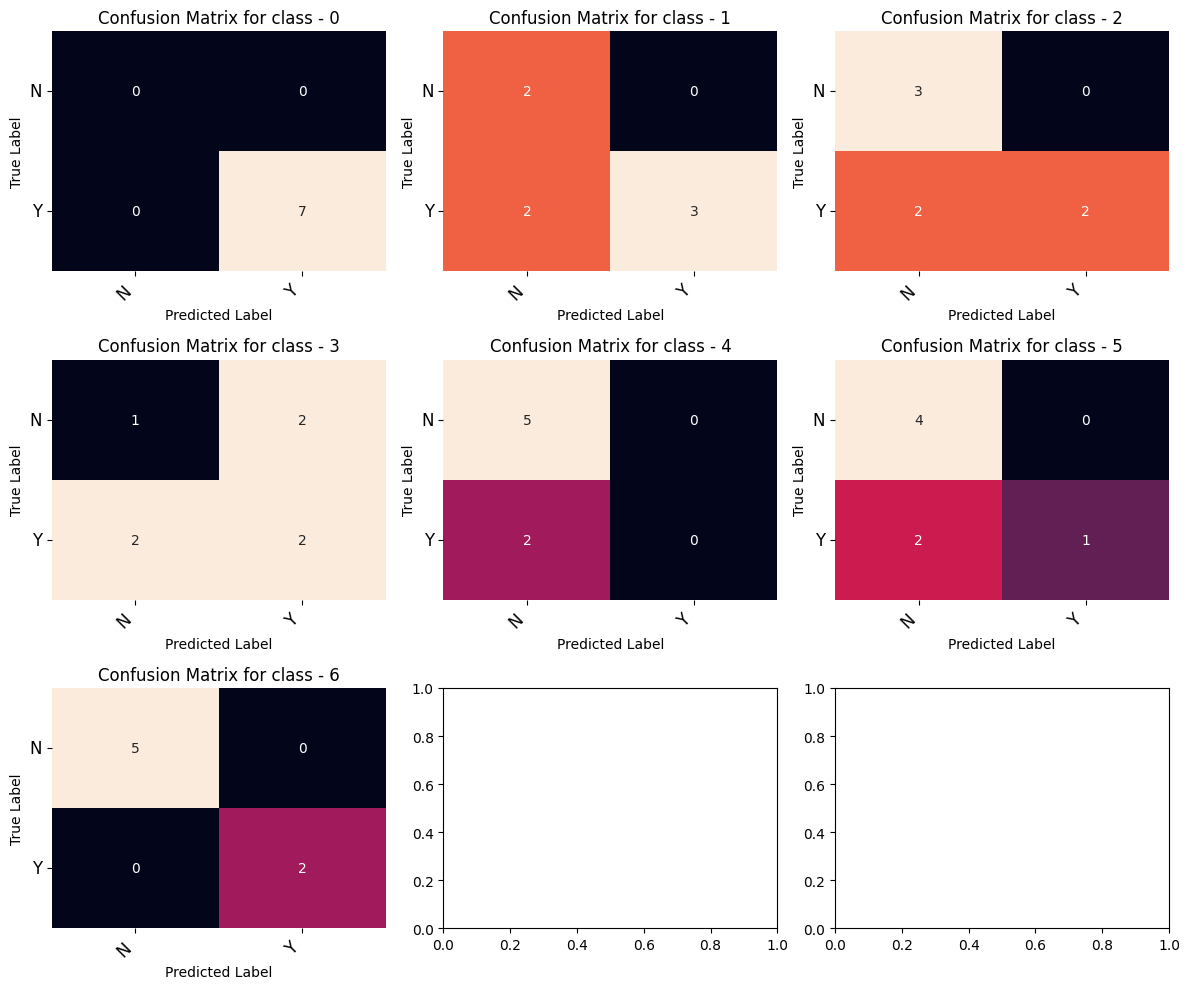

In [146]:
plot_multi_class_confusion_matrix(labels, multi_label_cm)

In [148]:
from transformers import TFAutoModelForTokenClassification, AutoTokenizer

# Load pre-trained tokenizer
model_name = "bert-base-cased"
tokenizer = AutoTokenizer.from_pretrained(model_name)

# Load pre-trained model for token classification
num_labels = 7  # Number of NER classes, including "O" for non-entities
model = TFAutoModelForTokenClassification.from_pretrained(model_name, num_labels=num_labels)


tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/436k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/436M [00:00<?, ?B/s]

All PyTorch model weights were used when initializing TFBertForTokenClassification.

Some weights or buffers of the TF 2.0 model TFBertForTokenClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [164]:
tokenized_inputs = tokenizer(
    X_train,
    truncation=True,
    is_split_into_words=True,
    padding="max_length",  # Padding to max length
    max_length=MAX_SEQUENCE_LENGTH,
    return_tensors="tf"
)

In [165]:
tokenized_inputs["labels"] = tf.convert_to_tensor([y_train])

In [166]:
dataset = tf.data.Dataset.from_tensor_slices(
    tokenized_inputs
).batch(BATCH_SIZE)

In [167]:
model.summary()

Model: "tf_bert_for_token_classification"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bert (TFBertMainLayer)      multiple                  107719680 
                                                                 
 dropout_37 (Dropout)        multiple                  0 (unused)
                                                                 
 classifier (Dense)          multiple                  5383      
                                                                 
Total params: 107725063 (410.94 MB)
Trainable params: 107725063 (410.94 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [168]:
model.compile(optimizer="adam", loss=loss)
early_stopping_callback = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    patience=3
)
model.fit(
    dataset,
    epochs=NUM_EPOCHS,
    )

Epoch 1/500


ValueError: Cannot generate a hashable key for IteratorSpec({'input_ids': TensorSpec(shape=(None, 291), dtype=tf.int32, name=None), 'token_type_ids': TensorSpec(shape=(None, 291), dtype=tf.int32, name=None), 'attention_mask': TensorSpec(shape=(None, 291), dtype=tf.int32, name=None), 'labels': TensorSpec(shape=(None, 24, 291), dtype=tf.int32, name=None)},) because the _serialize() method returned an unsupproted value of type <class 'transformers.tokenization_utils_base.BatchEncoding'>

### 3. Evaluation

Overall, an f1 score of 60% is not very good. Initial instincts are that there isn't enough data to train the model on. Evaluation points are below:

1. Gather more data to train Transformer Model
2. Fine tune a pretrained model like BERT with data